# Project: Modeling the brain
<p><b>Author:</b> Joeri van Wijngaarden<br>
<b>Date:</b> 05-12-2018<br>
<b>Source:</b> http://joerivanwijngaarden.com<br>
<b>Github:</b> http://github.com/tingidev<p>

## Part 1 - An active neuron

In [1]:
# Load packages
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import ipdb
%matplotlib inline

In [2]:
def plot_stimulation(ax, t_start, t_end, time_vector, y):
    # Visualising our stimulation protocol
    ax.plot([0,t_start], [y,y], color='k', linewidth=2)
    ax.plot([t_start,t_start], [y,y+10], color='k', linewidth=2)
    ax.plot([t_start,t_end], [y+10,y+10], color='k', linewidth=2)
    ax.plot([t_end,t_end], [y+10,y], color='k', linewidth=2)
    ax.plot([t_end,time_vector[-1]], [y,y], color='k', linewidth=2)
    ax.text(30, -55, 'trace', color='c', fontsize=12)
    ax.text(10, y+5, 'stimulation', color='k', fontsize=12)
    
def plot_spikes(ax, fired, spec):
    # Highlighting the locations when the neuron is active
    for i in np.where(fired==1)[0]:
        ax.plot([i,i], [-35,20], spec, linewidth=2)
        ax.plot(i, -35, 'rx', markersize=6)

In [3]:
# Simulation params
duration = 1000 # in ms
dt = 1 # timestep in ms
time = np.arange(dt, duration, dt) # time vector

# State variables
V = np.zeros( duration//dt ) # membrane potential
V[0] = -50. # initialise start value
fired = np.zeros ( duration//dt ) # stores when the neuron is active

# Params
V_rev = 0. # input reverse potential
V_leak = -75. # leak current reverse potential
V_thr = -35. # threshold after which the cell fires
V_reset = -50. # reset value after firing
g_leak = 0.035 # leak conductance (fixed value)
C = 2. # membrane capacitance constant

# Starting simulation
for t in time:

    # Apply small input current between t=200 to t=600ms
    if t>200 and t<600:
        I_in = 1.6 # arbitrary value for now
    else:
        I_in = 0.

    # Leak current (Eq. 2)
    I_leak = g_leak * ( V[t-1] - V_leak )

    # Update membrane potential (Eq. 1)
    dV = 1/C * dt * ( I_in - I_leak )
    V[t] = V[t-1] + dV

    # Check for spike
    if V[t] >= V_thr:
        fired[t] = 1
        V[t] = V_reset

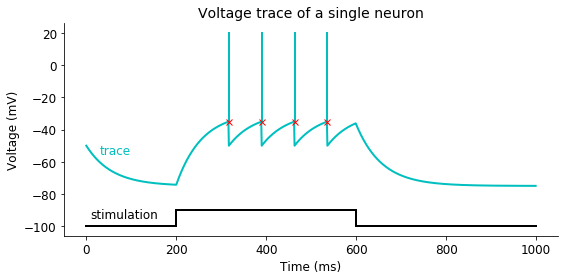

In [4]:
# Plotting simulation result
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(V, color='c', linewidth=2)
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Voltage (mV)', fontsize=12)
ax.set_title('Voltage trace of a single neuron', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in np.where(fired==1)[0]:
    """
    In reality, an output signal is a very fast change from the threshold value 
    of -30mV to +20mV in just a few ms. We add some vertical lines for 
    visualization purposes only.
    
    """
    ax.plot([i,i], [-35,20], 'c-', linewidth=2)
    ax.plot(i, -35, 'rx', markersize=6)
plot_stimulation(ax, 200, 600, time, -100)

plt.tight_layout()

In [5]:
class Neuron():
    """ Initialise a neuron with a pre-set of parameter values """
    
    def __init__(self):
        # Params
        self.V_rev = 0. # input reverse potential
        self.V_leak = -75. # leak current reverse potential
        self.V_T = 120. # calcium current reverse potential
        self.V_h = -70. # calcium (de)inactivation threshold
        self.V_thr = -35. # threshold after which the cell fires
        self.V_reset = -60. # reset value after firing
        self.g_leak = 0.035 # leak conductance (fixed value)
        self.g_T = 0.07 # calcium conductance
        self.C = 2. # membrane capacitance constant
        self.tau_plus = 100. # time constant for duration of calcium burst
        self.tau_minus = 20. # time-constant for inactivation of calcium burst

    def initialise(self, duration, dt):
        # State variables
        self.V = np.zeros( duration//dt ) # membrane potential
        self.V[0] = self.V_reset # initialise start value
        self.fired = np.zeros ( duration//dt ) # stores when the neuron is active
        self.h = np.zeros( duration//dt ) # activation variable
        
    def update(self, t, I_in):        
        # Leak current (Eq. 2)
        I_leak = self.g_leak * ( self.V[t-1] - self.V_leak )
        
        # Calcium current (Eq. 3)
        I_T = self.h[t-1] * self.g_T * ( self.V[t-1] - self.V_T )
        
        # Update membrane potential (Eq. 1)
        dV = 1/self.C * dt * ( I_in - I_leak - I_T )
        self.V[t] = self.V[t-1] + dV
        
        # Update h (Eq. 4)
        if self.V[t-1] >= self.V_h: #inactive
            dh = dt * -self.h[t-1] / self.tau_minus # relaxes to zero when inactive over time-constant tau_min
        else: #active
            dh = dt * ( 1-self.h[t-1] ) / self.tau_plus # reaches maximum of 1 when active over time-constant tau_plus
        self.h[t] = self.h[t-1] + dh
        
        if t<400:
            self.V[t] = -72
        
        # Check for spike
        if self.V[t] >= self.V_thr:
            self.fired[t] = 1
            self.V[t] = self.V_reset

In [6]:
# Simulation params
duration = 1000 # in ms
dt = 1 # in ms
time = np.arange(dt, duration, dt) # time vector
neuron = Neuron()
neuron.initialise(duration, dt)

for t in time:

    # Apply small input current between t=200 to t=600ms
    if t > 400 and t < 800:
        I_in = 1.6
    else:
        I_in = 0.

    # Update
    neuron.update(t, I_in)

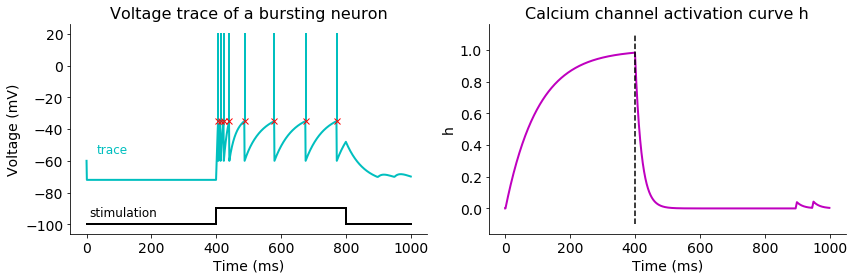

In [7]:
# Plotting simulation result
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

# Voltage trace
axs[0].plot(neuron.V, color='c', linewidth=2)
axs[0].set_xlabel('Time (ms)', fontsize=14)
axs[0].set_ylabel('Voltage (mV)', fontsize=14)
axs[0].set_title('Voltage trace of a bursting neuron', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
plot_spikes(axs[0], neuron.fired, 'c-')
plot_stimulation(axs[0], 400, 800, time, -100)

# Activation trace
axs[1].plot(neuron.h, color='m', linewidth=2)
axs[1].plot([400,400], [-0.1,1.1], 'k--')
axs[1].set_title('Calcium channel activation curve h', fontsize=16)
axs[1].set_xlabel('Time (ms)', fontsize=14)
axs[1].set_ylabel('h', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

plt.tight_layout()

## Part 2 - Network interactions

In [8]:
def generate_matrix(num_exc, num_inh, weight_exc, weight_inh, prob_exc, prob_inh):
    # Generates a matrix of excitatory and inhibitory connections
    num_tot = num_exc + num_inh
    
    # Excitatory matrix
    r_exc = np.random.rand(num_exc, num_tot) > prob_exc
    mat_exc = weight_exc * np.random.rand(num_exc, num_tot)
    mat_exc[r_exc] = 0
    
    # Inhibitory matrix
    r_inh = np.random.rand(num_inh, num_tot) > prob_inh
    mat_inh = weight_inh * np.random.rand(num_inh, num_tot)
    mat_inh[r_inh] = 0
    
    # Combine both
    mat_tot = np.concatenate( (mat_exc,mat_inh), axis=0 )
    
    return mat_tot

In [9]:
class Neuron():
    """ Initialise a neuron with a pre-set of parameter values """
    
    def __init__(self): 
        # Params
        self.V_rev = 0. # input reverse potential
        self.V_leak = -75. # leak current reverse potential
        self.V_T = 120. # calcium current reverse potential
        self.V_E = 0. # exc. current reverse potential
        self.V_I = -85. # inh. current reverse potential
        self.V_h = -70. # calcium (de)inactivation threshold
        self.V_thr = -35. # threshold after which the cell fires
        self.V_reset = -60. # reset value after firing
        self.g_leak = 0.035 # leak conductance (fixed value)
        self.g_T = 0.07 # calcium conductance
        self.C = 2. # membrane capacitance constant
        self.tau_plus = 100. # time constant for duration of calcium burst
        self.tau_minus = 20. # time-constant for inactivation of calcium burst
        self.tau_E = 10. # time-constant for exc. synapses
        self.tau_I = 75. # time-constant for inh. synapses
        self.gain_E = 0.1 # exc. control constant
        self.gain_I = 0.1 # inh. control constant

    def initialise(self, duration, dt):
        # State variables
        self.V = np.zeros( duration//dt ) # membrane potential
        self.V[0] = self.V_reset # initialise start value
        self.fired = np.zeros ( duration//dt ) # stores when the neuron is active
        self.h = np.zeros( duration//dt ) # activation variable
        self.g_E = 0. # exc. synapse conductance
        self.g_I = 0. # inh. synapse conductance
        
    def update(self, t, I_app, input_E, input_I):        
        # Leak current (Eq. 2)
        I_leak = self.g_leak * ( self.V[t-1] - self.V_leak )
        
        # Calcium current (Eq. 3)
        I_T = self.h[t-1] * self.g_T * ( self.V[t-1] - self.V_T )
        
        # Exc. conductances
        if input_E > 0:
            dg_E = self.gain_E * input_E
        else:
            dg_E = 0
        self.g_E = self.g_E + dg_E - ( self.g_E/self.tau_E )
        
        # Inh. conductances
        if input_I > 0:
            dg_I = self.gain_I * input_I
        else:
            dg_I = 0
        self.g_I = self.g_I + dg_I - ( self.g_I/ self.tau_I )
        
        # Synaptic currents
        I_E = self.g_E * ( self.V[t-1] - self.V_E )
        I_I = self.g_I * ( self.V[t-1] - self.V_I )
        
        # Update membrane potential (Eq. 1)
        dV = 1/self.C * dt * ( I_app - I_leak - I_T - I_E - I_I )
        self.V[t] = self.V[t-1] + dV
        
        # Update h (Eq. 4)
        if self.V[t-1] >= self.V_h: #inactive
            dh = dt * -self.h[t-1] / self.tau_minus # relaxes to zero when inactive over time-constant tau_min
        else: #active
            dh = dt * ( 1-self.h[t-1] ) / self.tau_plus # reaches maximum of 1 when active over time-constant tau_plus
        self.h[t] = self.h[t-1] + dh
        
        # Check for spike
        if self.V[t] >= self.V_thr:
            self.fired[t] = 1
            self.V[t] = self.V_reset
            active = 1
        else:
            active = 0
            
        return active

In [10]:
# Simulation params
duration = 1000 # in ms
dt = 1 # in ms
time = np.arange(dt, duration, dt) # time vector
exc = Neuron()
inh = Neuron()
exc.initialise(duration, dt)
inh.initialise(duration, dt)
spike_exc=0 # initialise
spike_inh=0 # initialise

for t in time:

    # Apply input current between t=400 to t=800ms
    if t > 400 and t < 800:
        I_in = 12 # use value of 4 for figure 3
    else:
        I_in = 0.

    # Update
    spike_exc = exc.update(t, I_in, 0, spike_inh)
    spike_inh = inh.update(t, 0, spike_exc, 0)

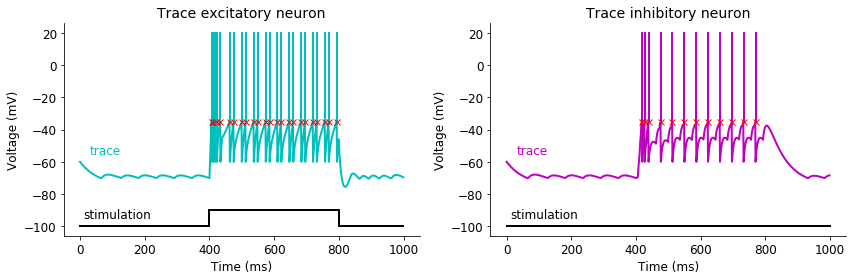

In [11]:
# Plotting simulation result
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

for i in range(2):

    if i==0:
        axs[i].plot(exc.V,'c',linewidth=2)
        plot_spikes(axs[i], exc.fired, 'c-')
        axs[i].set_title('Trace excitatory neuron', fontsize=14)
        plot_stimulation(axs[i],400,800,time,-100)
    else:
        axs[i].plot(inh.V,'m',linewidth=2)
        plot_spikes(axs[i], inh.fired, 'm-')
        axs[i].set_title('Trace inhibitory neuron', fontsize=14)
        axs[i].text(10,-95,'stimulation',color='k',fontsize=12)
        axs[i].text(30,-55,'trace',color='m',fontsize=12)
        axs[i].plot([0,duration],[-100,-100],'k',linewidth=2)
    axs[i].set_xlabel('Time (ms)', fontsize=12)
    axs[i].set_ylabel('Voltage (mV)', fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

plt.tight_layout()

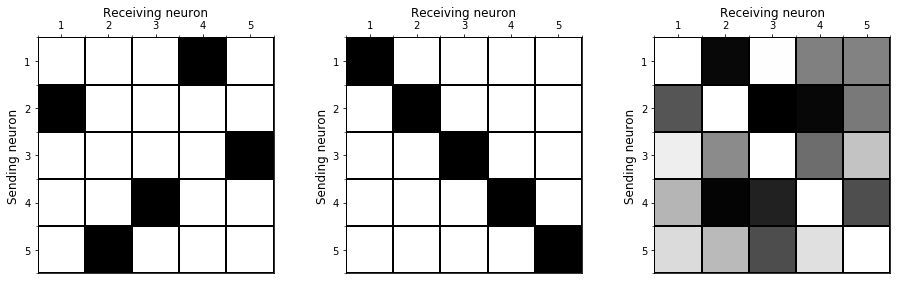

In [12]:
# Generate connectivity matrix examples
n_examples = 5
fig, axs = plt.subplots(ncols=3, figsize=(13,4))
i=0

for ax in axs:
   
    mat = np.zeros( (n_examples, n_examples) )
    
    if i==0:
        mat[0,3] = 1
        mat[1,0] = 1
        mat[2,4] = 1
        mat[3,2] = 1
        mat[4,1] = 1
    elif i==1:
        mat = np.identity(n_examples)
    else:
        mat = np.random.rand(n_examples,n_examples)
        np.fill_diagonal(mat, 0)
        
    ax.imshow(mat, cmap='gray_r', origin='upper')
    ax.xaxis.tick_top()
    ax.set_xticks(np.linspace(0,4,5))
    ax.set_yticks(np.linspace(0,4,5))
    ax.set_xticklabels(['1','2','3','4','5'])
    ax.set_yticklabels(['1','2','3','4','5'])
    ax.set_xticks(np.linspace(-0.5,4.5,6), minor=True)
    ax.set_yticks(np.linspace(-0.5,4.5,6), minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    ax.set_ylabel('Sending neuron', fontsize=12)
    ax.set_xlabel('Receiving neuron', fontsize=12)
    ax.xaxis.set_label_position('top') 
    i+=1

plt.tight_layout()

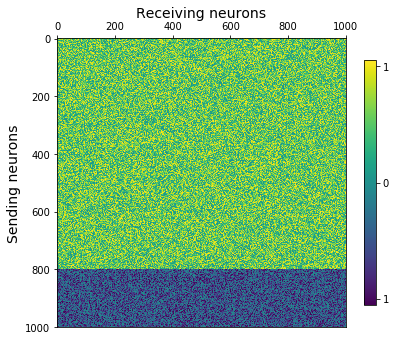

In [13]:
# Network connectivity visualization
mat = generate_matrix(800, 200, 1, -1, 1, 1)
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.imshow(mat, origin='upper')
ax.xaxis.tick_top()
ax.set_ylabel('Sending neurons', fontsize=14)
ax.set_xlabel('Receiving neurons', fontsize=14)
ax.xaxis.set_label_position('top') 
cbar = fig.colorbar(cax, shrink=0.6, ticks=[-0.95,0,0.95])
cbar.ax.set_yticklabels(['1', '0', '1'])

plt.tight_layout()

In [14]:
class Network():
    """ Initialise a network of neurons with vectorised equations """
    
    def __init__(self, num_exc, num_inh): 
        # Params
        self.V_rev = 0. # input reverse potential
        self.V_leak = -69. # leak current reverse potential
        self.V_T = 120. # calcium current reverse potential
        self.V_E = 0. # exc. current reverse potential
        self.V_I = -85. # inh. current reverse potential
        self.V_h = -70. # calcium (de)inactivation threshold
        self.V_thr = -35. # threshold after which the cell fires
        self.V_reset = -60. # reset value after firing
        self.g_leak = 0.035 # leak conductance (fixed value)
        self.g_T = 0.07 # calcium conductance
        self.C = 2. # membrane capacitance constant
        self.tau_plus = 100. # time constant for duration of calcium burst
        self.tau_minus = 20. # time-constant for inactivation of calcium burst
        self.tau_E = 10. # time-constant for exc. synapses
        self.tau_I = 75. # time-constant for inh. synapses
        self.gain_E = 0.1 # exc. control constant
        self.gain_I = 1 # inh. control constant
        self.num_E = num_exc # number of exc. neurons
        self.num_I = num_inh # number of inh. neurons
        self.num_T = num_exc + num_inh # total number of neurons

    def initialise(self, duration, dt):
        # State variables
        self.V = np.zeros( (self.num_T, duration//dt) ) # membrane potential (vectorised)
        self.V[:,0] = self.V_reset # initialise start value (vectorised)
        self.fired = np.zeros ( (self.num_T, duration//dt) ) # activity matrix (vectorised)
        self.h = np.zeros( self.num_T ) # calcium activation variable (vectorised)
        self.g_E = np.zeros( self.num_T ) # exc. synapse conductance (vectorised)
        self.g_I = np.zeros( self.num_T ) # inh. synapse conductance (vectorised)
        
    def generate_connectivity(self, weight_E, weight_I, prob_E, prob_I):
        # Randomize connectivity matrix W
        self.W = generate_matrix(self.num_E, self.num_I, weight_E, weight_I, prob_E, prob_I)
        
    def update(self, t, I_app):        
        # Leak current (Eq. 2) - (vectorised)
        I_leak = self.g_leak * ( self.V[:,t-1] - self.V_leak )
        
        # Calcium current (Eq. 3) - (vectorised)
        I_T = self.h * self.g_T * ( self.V[:,t-1] - self.V_T )
        
        # Exc. conductances (vectorised)
        fired_E = np.where( self.fired[:self.num_E,t-1] == 1 )[0]
        if fired_E.size > 0:
            dg_E = self.gain_E * np.sum(self.W[fired_E,:], axis=0 )
        else:
            dg_E = np.zeros(self.num_T)
        self.g_E = self.g_E + dg_E - ( self.g_E / self.tau_E )
        
        # Inh. conductances (vectorised)
        fired_I = np.where( self.fired[self.num_E:,t-1] == 1 )[0]
        if fired_I.size > 0:
            fired_I += self.num_E
            dg_I = self.gain_I * np.sum(self.W[fired_I,:], axis=0 )
        else:
            dg_I = np.zeros(self.num_T)
        self.g_I = self.g_I + dg_I - ( self.g_I / self.tau_I )
        
        # Synaptic currents (vectorised)
        I_E = self.g_E * ( self.V[:,t-1] - self.V_E )
        I_I = self.g_I * ( self.V[:,t-1] - self.V_I )
        
        # Update membrane potential (Eq. 1) - (vectorised)
        dV = 1/self.C * dt * ( I_app - I_leak - I_T - I_E - I_I )
        self.V[:,t] = self.V[:,t-1] + dV
        
        # Update h (Eq. 4) - (vectorised)
        h_active = np.where( self.V[:,t-1] >= self.V_h )[0]
        h_inactive = np.where( self.V[:,t-1] < self.V_h )[0]
        dh = np.zeros(self.num_T)
        dh[h_active] = dt * -self.h[h_active] / self.tau_minus # relaxes to zero when inactive
        dh[h_inactive] = dt * ( 1-self.h[h_inactive] ) / self.tau_plus # reaches maximum of 1 when active
        self.h = self.h + dh
        
        # Check for spike - (vectorised)
        fired = np.where( self.V[:,t] >= self.V_thr )[0]
        if fired.size > 0:
            self.fired[fired,t] = 1
            self.V[fired,t] = self.V_reset

In [19]:
# Simulation params
duration = 2000 # in ms
dt = 1 # in ms
time = np.arange(dt, duration, dt) # time vector
network = Network(800, 200)
network.initialise(duration, dt)

# Connectivity params
weight_exc = 0.06 # try 0.0 / 0.04 / 0.06
weight_inh = 0.01
prob_exc = 0.1
prob_inh = 0.5
network.generate_connectivity(weight_exc, weight_inh, prob_exc, prob_inh)

# Input params
weight_input = 10
prob_input_exc = 0.5
prob_input_inh = 0.3
r = np.append( (np.ones(800)*prob_input_exc), (np.ones(200)*prob_input_inh) )

for t in time:
    
    I_app = np.zeros(1000)
    
    if t > 100:
        I_app = weight_input * np.random.rand(1000)
        rnd = np.random.rand(1000)
        idx = np.where(rnd > r)
        I_app[idx] = 0

    network.update(t, I_app)    

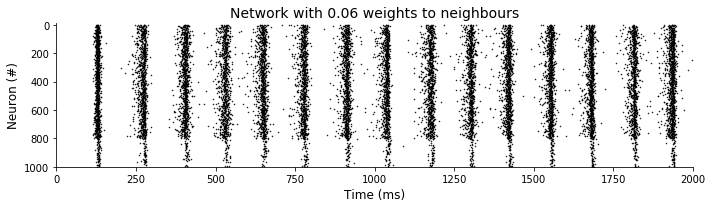

In [20]:
# Plot network simulation
fig, ax = plt.subplots(figsize=(10,3))
# cm = ax.imshow(network.fired, cmap='Greys')
where = np.where(network.fired==1)
ax.plot(where[1],where[0],'k.',markersize=1)
ax.set_xlim([0,2000])
ax.set_ylim([-10,1000])
ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Neuron (#)', fontsize=12)
ax.set_title('Network with 0.06 weights to neighbours', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.gca().invert_yaxis()

plt.tight_layout()